# Traditional machine learning models for age prediction on EEG data

This notebook uses traditional ML methods to predict the age of infants using EEG data. The EEG data is preprocessed and features are extracted as shown in the notebook 'Deep learning EEG_dataset preprocessing'. 

In [1]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_MODELS, PATH_DATA_PROCESSED_ML

## Load preprocessed data

Steps:

1. Get all the files in the output folder
2. Get the full paths of the files without the .h5 or .csv extensions
3. Load the features from the .h5 files
4. Assign the proper labels to the files based on the metadata
5. Assign the subject's code to the files based on the metadata
6. Split the data into a training, validation and test set (NOTE: make sure data points from same subjects don't end up in same set

In [2]:
from sklearn.model_selection import train_test_split

# Step 1: Get all the files in the output folder
file_names = os.listdir(PATH_DATA_PROCESSED_ML)

# Step 2: Get the full paths of the files (without extensions)
files = [os.path.splitext(os.path.join(PATH_DATA_PROCESSED_ML, file_name))[0] for file_name in fnmatch.filter(file_names, "*.h5")]

# Step 3: Load the features
frames = []

for idx, feature_file in enumerate(files):
    df_features = pd.read_hdf(feature_file + ".h5")
    df_metadata = pd.read_csv(feature_file.replace("extracted_features_", "processed_data_") + ".csv")
    
    # Step 4: Assign labels
    df_features['label'] = df_metadata['age_months'][0]
    
    # Step 5: Assign subject code
    df_features['code'] = df_metadata['code'][0]
    frames.append(df_features)

df = pd.concat(frames) 

# Step 6: Split data in train, validation and test
# df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
# df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=42)

# df_train, df_test = train_test_split(df, test_size=0.15, random_state=42)

from sklearn.model_selection import GroupShuffleSplit

train_inds, temp_inds = next(GroupShuffleSplit(train_size=.7, n_splits=2, random_state = 42).split(df, None, groups=df['code']))

df_train = df.iloc[train_inds]
df_temp = df.iloc[temp_inds]

val_inds, test_inds = next(GroupShuffleSplit(train_size=.5, n_splits=2, random_state = 42).split(df_temp, None, groups=df_temp['code']))

df_val = df_temp.iloc[val_inds]
df_test = df_temp.iloc[test_inds]

feature_names = df.columns.values

In [3]:
print(f"Train/val/test proportions: {len(df_train)/len(df)}/{len(df_val)/len(df)}/{len(df_test)/len(df)}")

Train/val/test proportions: 0.699321126227247/0.15172284230786381/0.14895603146488928


In [4]:
X_train = df_train.drop(['label', 'code'], axis=1).reset_index(drop=True)
y_train = df_train['label'].reset_index(drop=True)
codes_train = df_train['code'].reset_index(drop=True)

X_val = df_val.drop(['label', 'code'], axis=1).reset_index(drop=True)
y_val = df_val['label'].reset_index(drop=True)
codes_val = df_val['code'].reset_index(drop=True)

X_test = df_test.drop(['label', 'code'], axis=1).reset_index(drop=True)
y_test = df_test['label'].reset_index(drop=True)
codes_test = df_test['code'].reset_index(drop=True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

# MARK: reducing from 64 bit float to 32 bit float, to reduce memory usage
X_train = pd.DataFrame(scaler.fit_transform(X_train)).astype('float32')
X_val = pd.DataFrame(scaler.fit_transform(X_val)).astype('float32')
X_test = pd.DataFrame(scaler.fit_transform(X_test)).astype('float32')

In [5]:
del(file_names, files, df, frames, df_features, df_metadata, df_train, df_test, df_val, df_temp, val_inds, test_inds, train_inds, temp_inds)

In [6]:
print(f"{X_train.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_train.memory_usage(deep=True)/1000000000}")
print(f"{X_val.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_val.memory_usage(deep=True)/1000000000}")
print(f"{X_test.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_test.memory_usage(deep=True)/1000000000}")

1.722009728
0.007653504
0.373602728
0.001660584
0.366789728
0.001630304


## Dummy regressor

Firstly, we make predictions with dummy regressors as a simple baseline to see whether other models learn "something". From the sklearn docs: "DummyRegressor is a regressor that makes predictions using simple rules. This regressor is useful as a simple baseline to compare with other (real) regressors."

In [7]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

# R2
score = dummy_regr.score(X_test, y_test)

# MSE
predictions = dummy_regr.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Dummy regressor (mean): R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Dummy regressor (mean): R-squared = -0.0016519194919402125, RMSE = 10.503584576350338 and MAE = 8.911966017575716.


In [8]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train, y_train)

# R2
score = dummy_regr.score(X_test, y_test)

# MSE
predictions = dummy_regr.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Dummy regressor (median): R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Dummy regressor (median): R-squared = -0.02082818546755738, RMSE = 10.603651585911287 and MAE = 8.814638746572966.


## Model 1: Random Forest regressor

In [30]:
%%time

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# parameters = {'n_estimators': [10, 25, 50, 100], 
#               'max_depth': [5, 10],
#               'max_features': ['sqrt', 'log2'],
#               'criterion' :['mse', 'mae'],
#               'ccp_alpha': list(np.linspace(0, 1, 10))
#              }

# parameters = {'n_estimators': [16], 
#               'max_depth': [5],
#               'max_features': ['sqrt']
#              }

# rf_clf = GridSearchCV(RandomForestRegressor(verbose=10), parameters, verbose=10, n_jobs=1)


rf_clf = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1, verbose=10)
rf_clf.fit(X_train, y_train)

output_file = os.path.join(PATH_MODELS, 'rf_clf.joblib')
dump(rf_clf, output_file)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100

building tree 5 of 100building tree 6 of 100
building tree 7 of 100building tree 8 of 100


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   58.0s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.6min


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.2min


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.6min


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.1min


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.5min


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.9min


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.2min remaining:   40.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.9min finished


CPU times: user 1h 53min 58s, sys: 47.5 s, total: 1h 54min 46s
Wall time: 16min 59s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/rf_clf.joblib']

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    rf_clf
except:
    rf_clf = load(os.path.join(PATH_MODELS, 'rf_clf.joblib'))    

# Update verbosity
rf_clf.verbose = 0

# R2
score = rf_clf.score(X_test, y_test)

# MSE
predictions = rf_clf.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Random Forest regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

del(rf_clf)

Performance of Random Forest regressor: R-squared = 0.29976782375319966, RMSE = 8.78213592367779 and MAE = 7.076599286523624.


## Model 2: Linear Support Vector Regressor

In [7]:
len(X_train)

956672

There are a lot of training examples in the training set. According to the sklearn docs: "The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples." 

They recommend using a linear SVR for large data sets. Therefore, let's try this first. If this doesn't work, we might split the training set in smaller sets, train multiple SVRs and average the outcomes.

In [8]:
from sklearn.utils import shuffle

# Take a subset of the training data for faster prototyping

# Shuffle data before using
X_train, y_train, codes_train = shuffle(X_train, y_train, codes_train, random_state=42)

# X_train_100000 = X_train.head(100000)
# y_train_100000 = y_train.head(100000)

n = len(X_train)/100  # Chunk size

chunked_X_train = np.array_split(X_train, 100)    
chunked_y_train = np.array_split(y_train, 100)

In [9]:
count = 0
for chunk in chunked_X_train:
    count += len(chunk)

print(count)

956672


In [10]:
len(chunked_X_train[0])

9567

In [36]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

linearsvr_clf  = make_pipeline(StandardScaler(),
                     LinearSVR(verbose=10))
linearsvr_clf.fit(X_train, y_train)

output_file = os.path.join(PATH_MODELS, 'linearsvr_clf.joblib')
dump(linearsvr_clf, output_file)

[LibLinear]

/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/linearsvr_clf.joblib']

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    linearsvr_clf
except:
    linearsvr_clf = load(os.path.join(PATH_MODELS, 'linearsvr_clf.joblib'))    

# Update verbosity
linearsvr_clf.verbose = 0

# R2
score = linearsvr_clf.score(X_test, y_test)

# MSE 
predictions = linearsvr_clf.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Linear Support Vector regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Linear Support Vector regressor: R-squared = 0.18748053550185728 and RMSE = 9.460106155012141.


## Model 3: (Non-linear) Support Vector Regressor

Let's try fitting a SVR on a (small) chunk of the training data. The parameter search below is quite small, but a broader search has been done before. However, a more fine-grained search is still necessary. The downside of SVR with a non-linear kernel is that it's very slow to fit and predict.

### Randomized search

In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import uniform
from sklearn.pipeline import make_pipeline

parameters = {'svr__C': uniform(50, 500),
              'svr__epsilon': uniform(2, 10),
              'svr__gamma': uniform(0.0001, 0.005)
}

pipe  = make_pipeline(StandardScaler(),
                      SVR(verbose=True, kernel='rbf'))

rs = RandomizedSearchCV(pipe, parameters, n_iter=300, cv=5, n_jobs=-1, verbose=10)
rs.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'svr_clf_rs.joblib')
dump(rs, output_file)

NameError: name 'StandardScaler' is not defined

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    rs
except:
    rs = load(os.path.join(PATH_MODELS, 'svr_clf_rs.joblib'))  

# R2
score = rs.score(X_test, y_test)

# MSE
predictions = rs.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Support Vector regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Support Vector regressor: R-squared = 0.3655311410902873 and RMSE = 8.41905968453532.


In [42]:
rs.best_params_

{'svr__C': 62.75534215376162,
 'svr__epsilon': 6.52063140593676,
 'svr__gamma': 0.0015588812348265573}

In [47]:
res_df = pd.DataFrame(rs.cv_results_)
res_df.sort_values(by=['rank_test_score']).head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,param_svr__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
65,50.483049,0.813903,11.004105,0.354420,62.7553,6.52063,0.00155888,"{'svr__C': 62.75534215376162, 'svr__epsilon': ...",0.378640,0.352382,0.342213,0.355930,0.389598,0.363752,0.017573,1
95,51.987874,0.564698,11.694473,0.149925,82.9868,6.35537,0.00152127,"{'svr__C': 82.98684283304459, 'svr__epsilon': ...",0.377454,0.350739,0.340394,0.352878,0.389137,0.362120,0.018177,2
11,69.776811,0.908279,15.971187,0.648246,74.3006,3.95923,0.00158948,"{'svr__C': 74.30062021011342, 'svr__epsilon': ...",0.381973,0.346294,0.335272,0.353694,0.385732,0.360593,0.019911,3
122,70.931876,0.599660,16.208164,0.597785,75.3688,3.51867,0.00138493,"{'svr__C': 75.36875999124737, 'svr__epsilon': ...",0.383890,0.345153,0.336102,0.351590,0.384439,0.360235,0.020149,4
51,55.371403,0.381032,12.595145,0.232462,123.686,5.75221,0.000646769,"{'svr__C': 123.6858634395875, 'svr__epsilon': ...",0.376228,0.347502,0.336513,0.348152,0.381950,0.358069,0.017747,5
257,66.513369,1.171978,14.017700,0.668937,103.011,4.6016,0.00146429,"{'svr__C': 103.01094408535872, 'svr__epsilon':...",0.377493,0.344886,0.332940,0.349401,0.384971,0.357938,0.019906,6
125,65.625069,0.619704,15.227950,0.253355,110.842,4.4584,0.00126384,"{'svr__C': 110.8423048053841, 'svr__epsilon': ...",0.378437,0.344284,0.331595,0.349056,0.383037,0.357282,0.020036,7
261,69.361036,0.361106,14.824828,0.994449,113.93,4.23828,0.001224,"{'svr__C': 113.93045640361544, 'svr__epsilon':...",0.378368,0.342979,0.330903,0.347936,0.381556,0.356348,0.020086,8
37,71.469218,0.606593,14.823627,0.794503,124.26,3.86364,0.000959965,"{'svr__C': 124.26042510606202, 'svr__epsilon':...",0.379784,0.343834,0.333220,0.344463,0.380124,0.356285,0.019735,9
16,67.259774,1.985945,15.372470,0.598997,56.8449,4.38187,0.00340855,"{'svr__C': 56.84494698101118, 'svr__epsilon': ...",0.369721,0.346879,0.332574,0.346955,0.381386,0.355503,0.017580,10


### Grid search

In [68]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

parameters = {'svr__C': [30, 40, 50, 60, 70, 80],
              'svr__epsilon': [3, 4, 5, 6, 7],
              'svr__gamma': ['scale', 'auto', 0.0015]
}

pipe  = make_pipeline(StandardScaler(),
                      SVR(verbose=True, kernel='rbf'))

gs = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=10)

gs.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'svr_clf_gs.joblib')
dump(gs, output_file)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31

[LibSVM]

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/svr_clf_gs.joblib']

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    gs
except:
    gs = load(os.path.join(PATH_MODELS, 'svr_clf_gs.joblib'))  

# R2
score = gs.score(X_test, y_test)

# MSE
predictions = gs.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Support Vector regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Support Vector regressor: R-squared = 0.3704274055160367 and RMSE = 8.386511373656239.


In [70]:
gs.best_params_

{'svr__C': 30, 'svr__epsilon': 5, 'svr__gamma': 'scale'}

In [71]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,param_svr__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,78.480846,0.274900,18.109673,0.115503,30,3,scale,"{'svr__C': 30, 'svr__epsilon': 3, 'svr__gamma'...",0.387437,0.347372,0.342176,0.362969,0.389639,0.365919,0.019708,18
1,78.575422,0.415047,18.351595,0.550710,30,3,auto,"{'svr__C': 30, 'svr__epsilon': 3, 'svr__gamma'...",0.387437,0.347372,0.342176,0.362969,0.389639,0.365919,0.019708,17
2,77.460607,0.235881,18.566331,0.185527,30,3,0.0015,"{'svr__C': 30, 'svr__epsilon': 3, 'svr__gamma'...",0.382953,0.349031,0.342955,0.360312,0.388912,0.364833,0.018204,29
3,72.220071,0.792610,16.005668,0.501847,30,4,scale,"{'svr__C': 30, 'svr__epsilon': 4, 'svr__gamma'...",0.387381,0.352735,0.343830,0.363617,0.391307,0.367774,0.018735,5
4,72.071294,0.284025,16.541555,0.588890,30,4,auto,"{'svr__C': 30, 'svr__epsilon': 4, 'svr__gamma'...",0.387381,0.352735,0.343830,0.363617,0.391307,0.367774,0.018735,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,72.842726,3.510390,19.518003,3.395048,80,6,auto,"{'svr__C': 80, 'svr__epsilon': 6, 'svr__gamma'...",0.373194,0.349964,0.337240,0.347513,0.383667,0.358316,0.017290,76
86,74.523264,3.471962,15.298929,0.262055,80,6,0.0015,"{'svr__C': 80, 'svr__epsilon': 6, 'svr__gamma'...",0.378445,0.351056,0.340248,0.353950,0.390020,0.362744,0.018496,46
87,63.547777,0.724069,13.180865,0.540073,80,7,scale,"{'svr__C': 80, 'svr__epsilon': 7, 'svr__gamma'...",0.369483,0.347866,0.334668,0.344106,0.379853,0.355195,0.016794,87
88,61.432022,0.797870,12.363378,0.684407,80,7,auto,"{'svr__C': 80, 'svr__epsilon': 7, 'svr__gamma'...",0.369483,0.347866,0.334668,0.344106,0.379853,0.355195,0.016794,88


The best SVR after small gridsearch on a subset of the data: 
{'svr__C': 50, 'svr__epsilon': 5, 'svr__gamma': 0.0015, 'svr__kernel': 'rbf'}

### SVR with best parameters

In [38]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

svr_clf  = make_pipeline(StandardScaler(),
                         SVR(verbose=True, kernel='rbf', gamma='scale', epsilon=5, C=30))
svr_clf.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'svr_clf.joblib')
dump(svr_clf, output_file)

[LibSVM]

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/svr_clf.joblib']

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    svr_clf
except:
    svr_clf = load(os.path.join(PATH_MODELS, 'svr_clf.joblib'))  

# R2
score = svr_clf.score(X_test, y_test)

# MSE
predictions = svr_clf.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Support Vector regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Support Vector regressor: R-squared = 0.2972301014476345 and RMSE = 8.798035269039868.


Also tried SVR on whole data set -> Not possible within 3.5 full days

## Model 4: SGD Regressor

Fitting a SVR is too computationally expensive. Therefore, we try prediction with an SGD Regressor. According to the sklearn documentation, it's best to start with a RandomizedSearchCV to find reasonable hyperparameters. Therefore, we start with this.

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, loguniform

# specify parameters and distributions to sample from
parameters = {'sgdregressor__average': [True, False],
              'sgdregressor__l1_ratio': uniform(0, 1),
              'sgdregressor__alpha': loguniform(1e-6, 1e0),
              'sgdregressor__epsilon': uniform(0.1, 10),
             }

pipe = make_pipeline(StandardScaler(),
                     SGDRegressor(verbose=10))
pipe.get_params()

sgd_reg = RandomizedSearchCV(pipe, parameters, n_iter=20, cv=5, n_jobs=1, verbose=10)
sgd_reg.fit(X_train, y_train)

output_file = os.path.join(PATH_MODELS, 'sgd_reg.joblib')
dump(sgd_reg, output_file)

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('sgdregressor', SGDRegressor(verbose=10))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'sgdregressor': SGDRegressor(verbose=10),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'sgdregressor__alpha': 0.0001,
 'sgdregressor__average': False,
 'sgdregressor__early_stopping': False,
 'sgdregressor__epsilon': 0.1,
 'sgdregressor__eta0': 0.01,
 'sgdregressor__fit_intercept': True,
 'sgdregressor__l1_ratio': 0.15,
 'sgdregressor__learning_rate': 'invscaling',
 'sgdregressor__loss': 'squared_loss',
 'sgdregressor__max_iter': 1000,
 'sgdregressor__n_iter_no_change': 5,
 'sgdregressor__penalty': 'l2',
 'sgdregressor__power_t': 0.25,
 'sgdregressor__random_state': None,
 'sgdregressor__shuffle': True,
 'sgdregressor__tol': 0.001,
 'sgdregressor__validation_fraction': 0.1,
 'sgdregressor__verbose': 10,
 'sgdregressor__warm_start': False}

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    sgd_reg
except:
    sgd_reg = load(os.path.join(PATH_MODELS, 'sgd_reg.joblib'))  

# R2
score = sgd_reg.score(X_test, y_test)

# MSE
predictions = sgd_reg.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of SGD regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of SGD regressor: R-squared = -8613876701713962.0 and RMSE = 956595131.138941.


## Nystroem feature map  - SVR

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.kernel_approximation import Nystroem

feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=42,
                                n_components=100)

nystroem_approx_svr = Pipeline([("feature_map", feature_map_nystroem),
                                        ("svr", svm.LinearSVR(epsilon=5, C=30))])

nystroem_approx_svr.fit(X_train, y_train)
nystroem_approx_svr.score(X_train, y_train)

output_file = os.path.join(PATH_MODELS, 'nystroem_approx_svr.joblib')
dump(nystroem_approx_svr, output_file)

/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-0.008753980739107048

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    nystroem_approx_svr
except:
    nystroem_approx_svr = load(os.path.join(PATH_MODELS, 'nystroem_approx_svr.joblib'))  

# R2
score = nystroem_approx_svr.score(X_test, y_test)

# MSE
predictions = nystroem_approx_svr.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Nystroem LinearSVR regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Nystroem LinearSVR regressor: R-squared = -0.007994716809803792 and RMSE = 10.34803689522995.


## Model 5: Neural network

In [40]:
X_train.shape

(956672, 450)

### Helper functions

In [41]:
def plot_loss(history):
    """ Plots the MSE, RMSE, and MAE loss for the training and validation data over time """
    
    %matplotlib inline
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,12), dpi=200)

    ax1.plot(history.history['loss'], label='training data')  
    min_loss = min(history.history['val_loss'])
    val_plot1 = ax1.plot(history.history['val_loss'], label='validation data')
    ax1.axhline(y = min_loss, color = val_plot1[0].get_color(), linestyle = '--') 
    x0,x1 = ax1.get_xlim()
    ax1.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax1.set_title('MSE loss')
    ax1.set_ylabel("MSE")
    ax1.set_xlabel("epochs")
    ax1.legend()

    ax2.plot(history.history['root_mean_squared_error'], label='training data')
    min_loss = min(history.history['val_root_mean_squared_error'])
    val_plot2 = ax2.plot(history.history['val_root_mean_squared_error'], label='validation data')
    ax2.axhline(y = min_loss, color = val_plot2[0].get_color(), linestyle = '--') 
    x0,x1 = ax2.get_xlim()
    ax2.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax2.set_title('RMSE loss')
    ax2.set_ylabel("RMSE")
    ax2.set_xlabel("epochs")
    ax2.legend()
    
    ax3.plot(history.history['mean_absolute_error'], label='training data')    
    min_loss = min(history.history['val_mean_absolute_error'])
    val_plot3 = ax3.plot(history.history['val_mean_absolute_error'], label='validation data')
    ax3.axhline(y = min_loss, color = val_plot3[0].get_color(), linestyle = '--') 
    x0,x1 = ax3.get_xlim()
    ax3.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax3.set_title('MAE loss')
    ax3.set_ylabel("MAE")
    ax3.set_xlabel("epochs")
    ax3.legend()

In [42]:
input_shape=(450, )

### 'FC_regressor_01'

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
        
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_02'

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
        
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_03'

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(300, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
        
    model.add(Dense(200, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_04'

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
        
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_05'

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
        
    model.add(Dense(256, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

In [53]:
model = fully_connected_model()

optimizer = Adam(learning_rate=0.01, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=1e-07, 
                 amsgrad=False,
                 name='Adam')

model.build(input_shape)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               230912    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 299,265
Trainable params: 297,985
Non-trainable params: 1,280
____________________________________________

In [54]:
output_filename = 'FC_regressor_01' # MARK: Make sure to update
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=0.0001, verbose=1)

In [55]:
epochs = 1500

# fit network
history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
29896/29896 [==============================] - 84s 3ms/step - loss: 88.2964 - root_mean_squared_error: 9.3456 - mean_absolute_error: 7.7041 - val_loss: 80.3377 - val_root_mean_squared_error: 8.9631 - val_mean_absolute_error: 7.3992

Epoch 00001: val_loss improved from inf to 80.33772, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/FC_regressor_01.hdf5
Epoch 2/1500
29896/29896 [==============================] - 77s 3ms/step - loss: 81.1971 - root_mean_squared_error: 9.0109 - mean_absolute_error: 7.4715 - val_loss: 79.7002 - val_root_mean_squared_error: 8.9275 - val_mean_absolute_error: 7.3950

Epoch 00002: val_loss improved from 80.33772 to 79.70021, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/FC_regressor_01.hdf5
Epoch 3/1500
29896/29896 [==============================] - 76s 3ms/step - loss: 81.4796 - root_mean_squared_error: 9.0266 - mean_absolute_error: 7.4938 - val_loss: 77.9408 

29896/29896 [==============================] - 101s 3ms/step - loss: 83.2464 - root_mean_squared_error: 9.1239 - mean_absolute_error: 7.5920 - val_loss: 80.6310 - val_root_mean_squared_error: 8.9795 - val_mean_absolute_error: 7.5015

Epoch 00053: val_loss did not improve from 77.25674
Epoch 54/1500
29896/29896 [==============================] - 89s 3ms/step - loss: 83.1596 - root_mean_squared_error: 9.1192 - mean_absolute_error: 7.5907 - val_loss: 80.3650 - val_root_mean_squared_error: 8.9647 - val_mean_absolute_error: 7.5072

Epoch 00054: val_loss did not improve from 77.25674
Epoch 55/1500
29896/29896 [==============================] - 76s 3ms/step - loss: 83.2946 - root_mean_squared_error: 9.1266 - mean_absolute_error: 7.5949 - val_loss: 80.1143 - val_root_mean_squared_error: 8.9507 - val_mean_absolute_error: 7.4948

Epoch 00055: val_loss did not improve from 77.25674
Epoch 56/1500
29896/29896 [==============================] - 79s 3ms/step - loss: 83.5293 - root_mean_squared_error:

29896/29896 [==============================] - 61s 2ms/step - loss: 81.6369 - root_mean_squared_error: 9.0353 - mean_absolute_error: 7.5143 - val_loss: 78.5993 - val_root_mean_squared_error: 8.8656 - val_mean_absolute_error: 7.4171

Epoch 00107: val_loss did not improve from 77.25674
Epoch 108/1500
29896/29896 [==============================] - 61s 2ms/step - loss: 81.4086 - root_mean_squared_error: 9.0226 - mean_absolute_error: 7.5012 - val_loss: 78.6888 - val_root_mean_squared_error: 8.8707 - val_mean_absolute_error: 7.4178

Epoch 00108: val_loss did not improve from 77.25674
Epoch 109/1500
29896/29896 [==============================] - 64s 2ms/step - loss: 81.4018 - root_mean_squared_error: 9.0223 - mean_absolute_error: 7.5012 - val_loss: 79.0155 - val_root_mean_squared_error: 8.8891 - val_mean_absolute_error: 7.4003

Epoch 00109: val_loss did not improve from 77.25674
Epoch 110/1500
29896/29896 [==============================] - 62s 2ms/step - loss: 81.4988 - root_mean_squared_erro

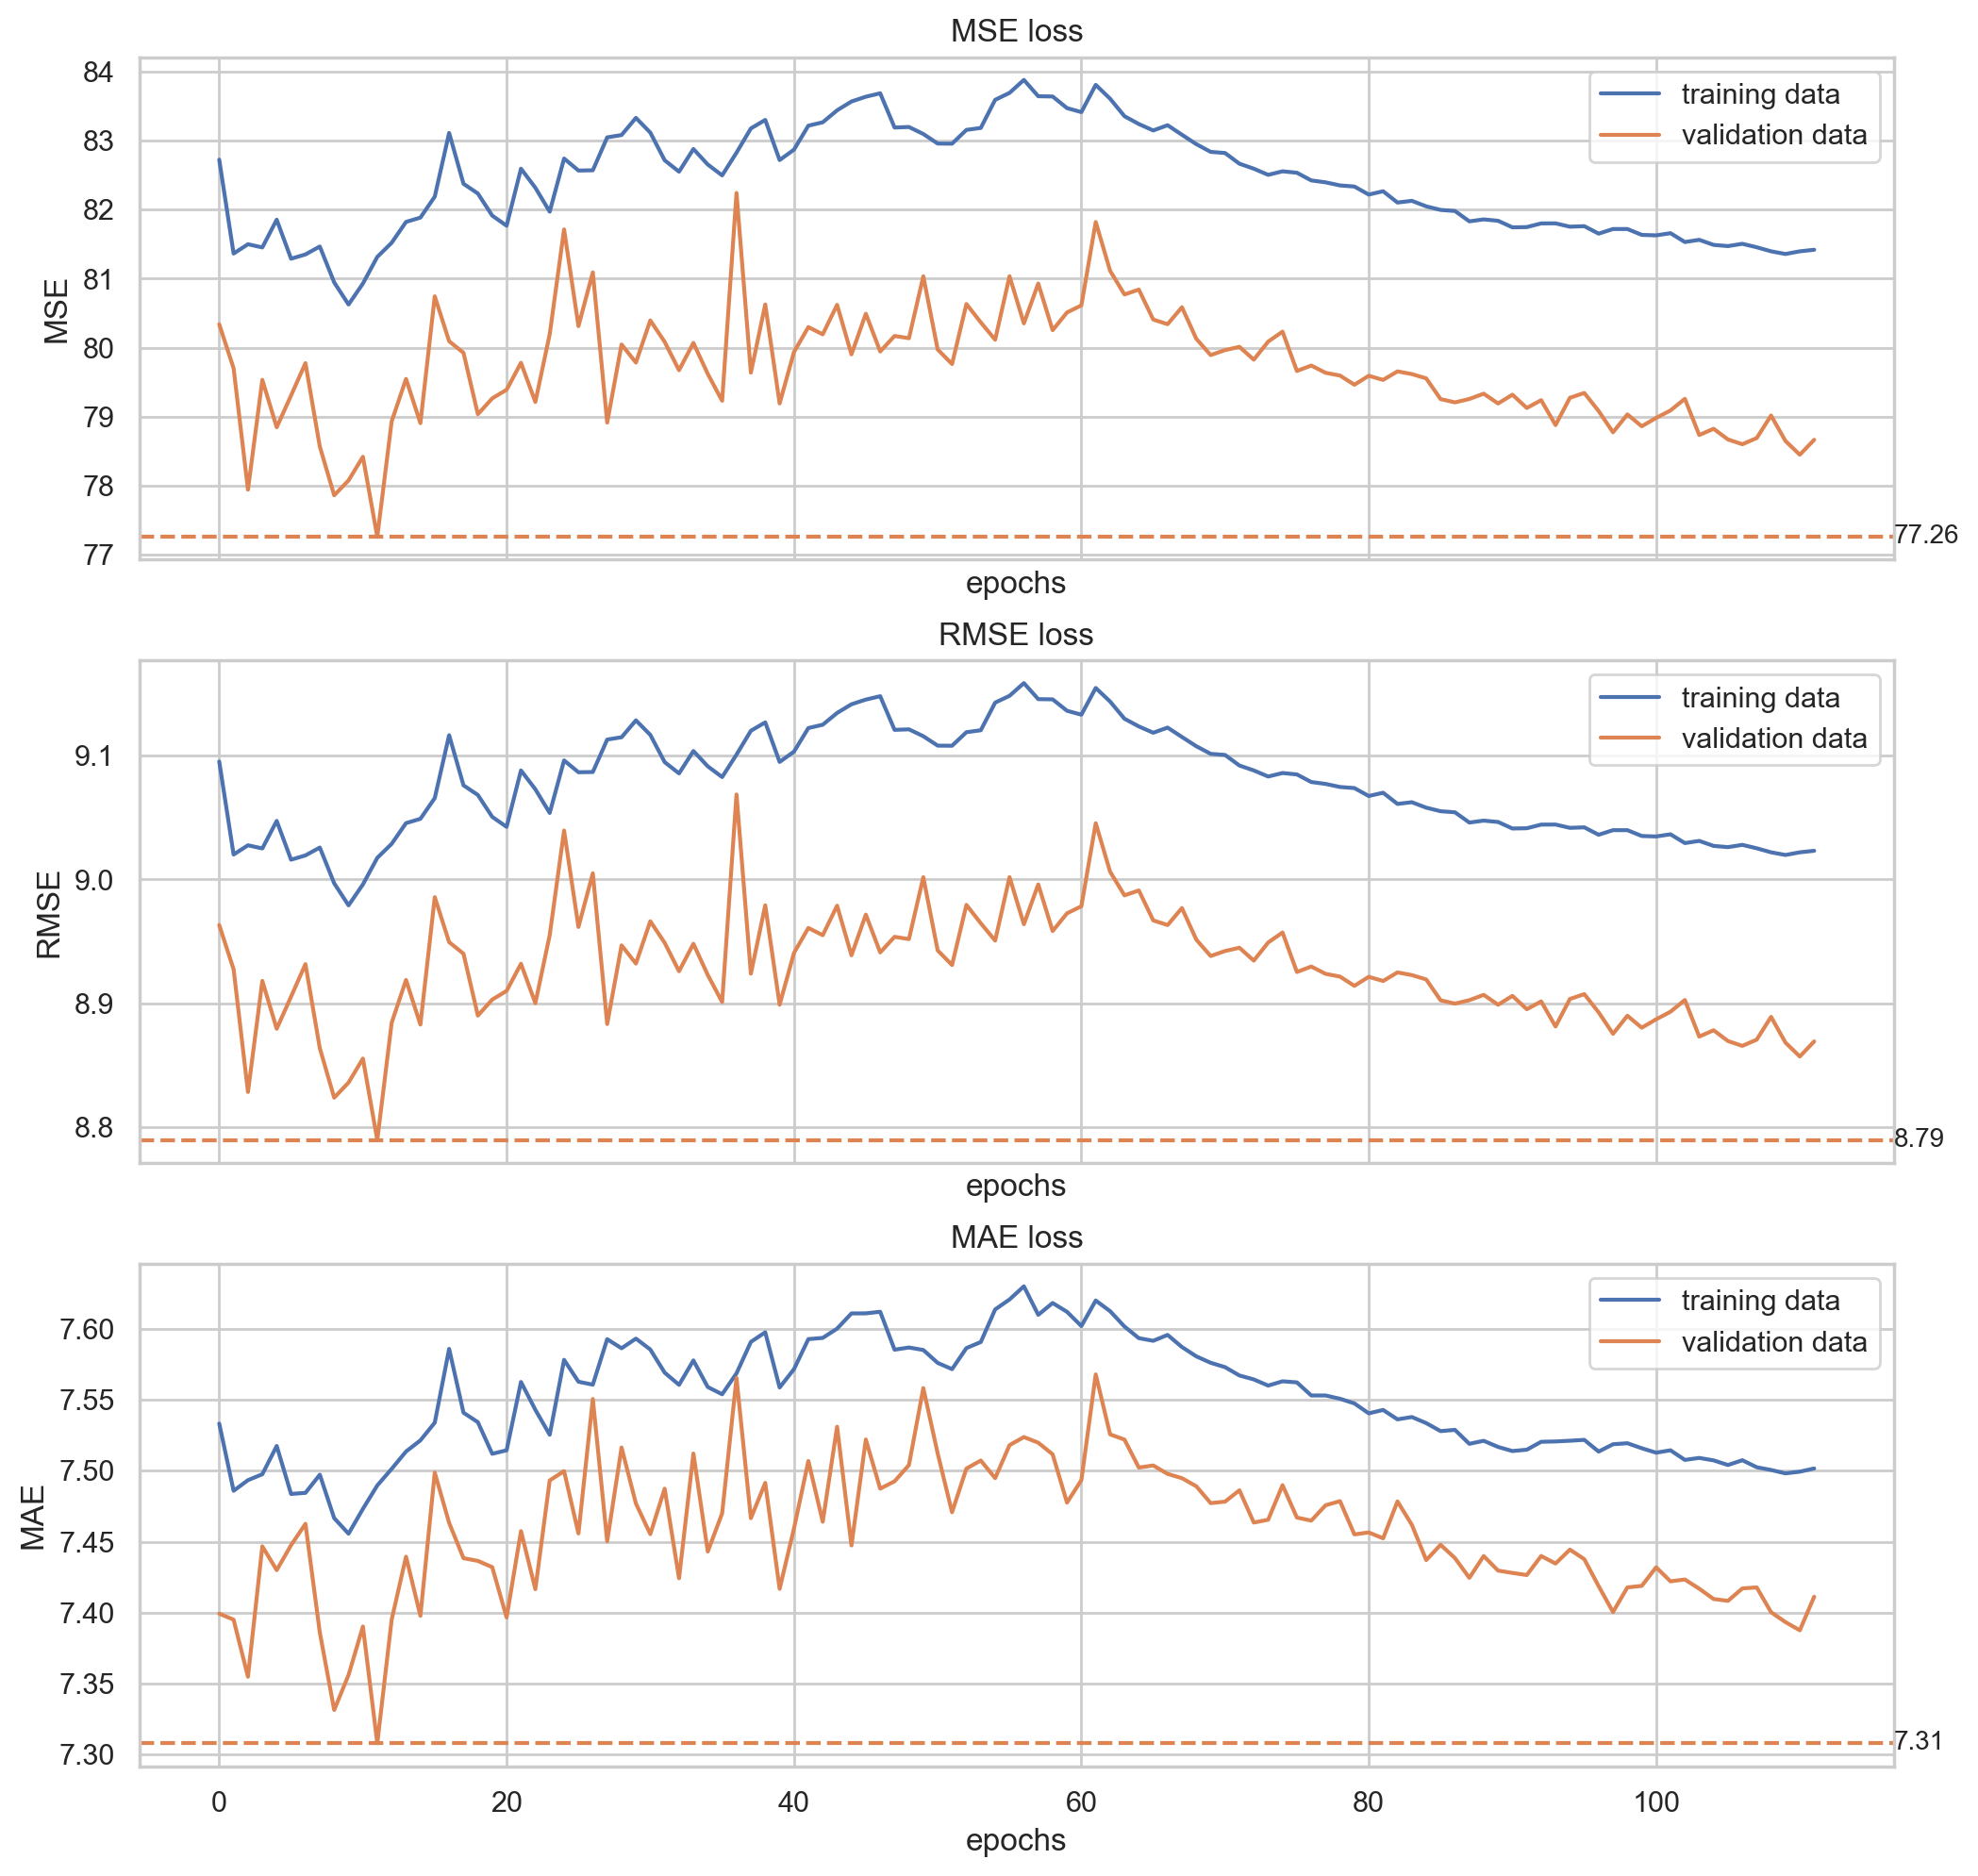

In [56]:
plot_loss(history)

In [57]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

filename = os.path.join(PATH_MODELS, 'FC_regressor_01')
model = tf.keras.models.load_model(filename + ".hdf5")

# MSE
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of simple FC neural network regressor: RMSE = {rmse} and MAE = {mae}.")

Performance of simple FC neural network regressor: RMSE = 8.962693403865986 and MAE = 7.322791660524111.


- Performance of 'FC_regressor_01': RMSE = 8.962693403865986 and MAE = 7.322791660524111. (Correct split)
- Performance of 'FC_regressor_02': RMSE = 8.89461832846391 and MAE = 7.288057913338504.
- Performance of 'FC_regressor_03': RMSE = 8.797764719465878 and MAE = 7.173652581160049.
- Performance of 'FC_regressor_04': RMSE = 8.918336755212458 and MAE = 7.307624677486689.
- Performance of 'FC_regressor_05': RMSE = 9.311148584537879 and MAE = 7.681811556401662.

## Model 6: Relevance Vector Regression

As we've seen above, the Support Vector Regressor takes a very long time to train (it didn't finish within 3.5 days). An alternative is the Relevance Vector Machine. This isn't included in sklearn, but there are two packages called 'scikit-rvm' and 'sklearn-rvm' using the sklearn API that has implemented this.

NOTE: Unfortunately memory usage blows up when trying to fit, therefore not possible.

### Try with best parameters found for SVR on subset data - Crashes due to very large memory usage

In [12]:
from sklearn_rvm import EMRVR

rvr_reg  = EMRVR(verbose=True, kernel='rbf', gamma='scale')
rvr_reg.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'rvr_reg.joblib')
dump(rvr_reg, output_file)

Iteration: 0
Alpha: [6.10662759e-02 1.10692941e-04 2.91744541e-02 ... 5.88932641e-04
 2.27818773e-05 3.21874056e-04]
Beta: 22702.46248276541
Gamma: [0.99762173 0.9999356  0.99990383 ... 0.99997627 0.99998241 0.99987779]
mu: [   4.04186931  -95.04858828   -5.85433839 ...  -41.20649932 -209.55438982
  -55.73618265]
Relevance Vectors: 9567

Iteration: 1
Alpha: [6.02591906e-02 1.10701679e-04 2.91151858e-02 ... 5.88886479e-04
 2.27808741e-05 3.22047425e-04]
Beta: 51650.75198893036
Gamma: [0.9998696  0.99999939 0.99990208 ... 0.99999408 0.99999892 0.99999687]
mu: [   4.07342826  -95.04786802   -5.86028893 ...  -41.20848149 -209.56073513
  -55.72449588]
Relevance Vectors: 9567

Iteration: 2
Alpha: [5.73101919e-02 1.10744173e-04 2.89083718e-02 ... 5.88638849e-04
 2.27797155e-05 3.22314965e-04]
Beta: 68418.13780005921
Gamma: [0.9997598  0.99999972 0.99995349 ... 0.99999739 0.99999952 0.99999857]
mu: [   4.17668711  -95.02964488   -5.88136537 ...  -41.21721664 -209.56613039
  -55.70141038]
Relev

Iteration: 25
Alpha: [5.00985152e-02 1.10857906e-04 2.83459240e-02 ... 5.87785319e-04
 2.27765387e-05 3.23032589e-04]
Beta: 178797.67105939722
Gamma: [0.99994179 0.99999991 0.99998575 ... 0.99999917 0.99999985 0.99999955]
mu: [   4.46760714  -94.98088981   -5.93952444 ...  -41.24716904 -209.58078536
  -55.63953029]
Relevance Vectors: 9565

Iteration: 26
Alpha: [5.00438942e-02 1.10858964e-04 2.83409721e-02 ... 5.87774267e-04
 2.27765454e-05 3.23036620e-04]
Beta: 220497.35554589305
Gamma: [0.99994371 0.99999992 0.99998698 ... 0.99999924 0.99999986 0.99999959]
mu: [   4.47004887  -94.98043714   -5.94004694 ...  -41.24755838 -209.580756
  -55.6391842 ]
Relevance Vectors: 9565

Iteration: 27
Alpha: [5.00595293e-02 1.10859125e-04 2.83423480e-02 ... 5.87771246e-04
 2.27765790e-05 3.23032643e-04]
Beta: 306957.6457424176
Gamma: [0.99994984 0.99999993 0.99998934 ... 0.99999939 0.99999989 0.99999966]
mu: [   4.46936446  -94.98036875   -5.93990978 ...  -41.24766731 -209.58060403
  -55.63952882]
Re

Iteration: 49
Alpha: [5.07336367e-02 1.10848833e-04 2.83969579e-02 ... 5.87849144e-04
 2.27773774e-05 3.22947399e-04]
Beta: 2087631.7424595582
Gamma: [0.99999253 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43966728  -94.98478102   -5.93422369 ...  -41.24494557 -209.57693975
  -55.64688015]
Relevance Vectors: 9565

Iteration: 50
Alpha: [5.07200697e-02 1.10849202e-04 2.83957404e-02 ... 5.87844798e-04
 2.27773662e-05 3.22949001e-04]
Beta: 2082310.111388763
Gamma: [0.99999254 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.44026102  -94.98462296   -5.9343509  ...  -41.24509804 -209.57699091
  -55.6467421 ]
Relevance Vectors: 9565

Iteration: 51
Alpha: [5.07327194e-02 1.10848899e-04 2.83970003e-02 ... 5.87848428e-04
 2.27773861e-05 3.22947716e-04]
Beta: 2089968.4840176867
Gamma: [0.9999925  0.99999999 0.99999882 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43970734  -94.98475267   -5.93421925 ...  -41.24497069 -209.57689944
  -55.64685288]


Iteration: 73
Alpha: [5.07356089e-02 1.10848855e-04 2.83970369e-02 ... 5.87848374e-04
 2.27773690e-05 3.22947218e-04]
Beta: 2089367.99593475
Gamma: [0.99999253 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43958098  -94.98477164   -5.93421543 ...  -41.24497256 -209.57697819
  -55.64689571]
Relevance Vectors: 9565

Iteration: 74
Alpha: [5.07341638e-02 1.10848870e-04 2.83970849e-02 ... 5.87846831e-04
 2.27773801e-05 3.22946860e-04]
Beta: 2090511.2620193472
Gamma: [0.99999254 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43964424  -94.98476542   -5.93421042 ...  -41.24502669 -209.57692724
  -55.64692663]
Relevance Vectors: 9565

Iteration: 75
Alpha: [5.07350924e-02 1.10848827e-04 2.83971617e-02 ... 5.87848481e-04
 2.27773693e-05 3.22946900e-04]
Beta: 2085709.2602623645
Gamma: [0.99999254 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43960361  -94.98478362   -5.9342024  ...  -41.24496882 -209.57697688
  -55.64692311]
R

Iteration: 97
Alpha: [5.07414460e-02 1.10848714e-04 2.83976806e-02 ... 5.87848852e-04
 2.27773812e-05 3.22946136e-04]
Beta: 2092293.5765325024
Gamma: [0.99999252 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.4393256   -94.98483221   -5.93414817 ...  -41.24495581 -209.5769223
  -55.64698895]
Relevance Vectors: 9565

Iteration: 98
Alpha: [5.07434819e-02 1.10848729e-04 2.83975144e-02 ... 5.87848759e-04
 2.27773841e-05 3.22946139e-04]
Beta: 2094586.0855856757
Gamma: [0.99999256 0.99999999 0.99999883 ... 0.99999994 0.99999999 0.99999996]
mu: [   4.43923663  -94.98482561   -5.93416555 ...  -41.24495906 -209.57690871
  -55.64698869]
Relevance Vectors: 9565

Iteration: 99
Alpha: [5.07364435e-02 1.10848874e-04 2.83972074e-02 ... 5.87849227e-04
 2.27773989e-05 3.22947159e-04]
Beta: 2090417.1377254587
Gamma: [0.99999257 0.99999999 0.99999883 ... 0.99999994 0.99999999 0.99999996]
mu: [   4.43954456  -94.98476341   -5.93419764 ...  -41.24494267 -209.57684042
  -55.64690088]


Iteration: 121
Alpha: [5.07410114e-02 1.10848721e-04 2.83973384e-02 ... 5.87848659e-04
 2.27773832e-05 3.22946340e-04]
Beta: 2090025.974263577
Gamma: [0.99999255 0.99999999 0.99999883 ... 0.99999994 0.99999999 0.99999996]
mu: [   4.43934468  -94.98482892   -5.93418394 ...  -41.24496259 -209.57691301
  -55.64697141]
Relevance Vectors: 9565

Iteration: 122
Alpha: [5.07240757e-02 1.10849006e-04 2.83961615e-02 ... 5.87845897e-04
 2.27773826e-05 3.22948487e-04]
Beta: 2080736.5025134168
Gamma: [0.99999255 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.44008572  -94.98470707   -5.9343069  ...  -41.24505949 -209.57691582
  -55.64678641]
Relevance Vectors: 9565

Iteration: 123
Alpha: [5.07366863e-02 1.10848889e-04 2.83970996e-02 ... 5.87848132e-04
 2.27773972e-05 3.22946928e-04]
Beta: 2089419.8171476955
Gamma: [0.9999925  0.99999999 0.99999882 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43953378  -94.98475712   -5.93420887 ...  -41.24498107 -209.57684862
  -55.6469207

Iteration: 145
Alpha: [5.07448557e-02 1.10848706e-04 2.83976345e-02 ... 5.87848499e-04
 2.27773931e-05 3.22945808e-04]
Beta: 2090349.4390266528
Gamma: [0.99999254 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43917649  -94.98483561   -5.93415299 ...  -41.24496818 -209.57686724
  -55.64701724]
Relevance Vectors: 9565

Iteration: 146
Alpha: [5.07488553e-02 1.10848678e-04 2.83981501e-02 ... 5.87850232e-04
 2.27774204e-05 3.22945432e-04]
Beta: 2096836.165866057
Gamma: [0.99999256 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.4390016   -94.98484739   -5.93409913 ...  -41.2449074  -209.57674184
  -55.64704966]
Relevance Vectors: 9565

Iteration: 147
Alpha: [5.07425618e-02 1.10848741e-04 2.83975950e-02 ... 5.87848593e-04
 2.27773911e-05 3.22946066e-04]
Beta: 2094024.3778736747
Gamma: [0.99999258 0.99999999 0.99999883 ... 0.99999994 0.99999999 0.99999996]
mu: [   4.43927693  -94.98482072   -5.93415714 ...  -41.24496489 -209.57687657
  -55.6469950

Iteration: 169
Alpha: [5.07319090e-02 1.10848891e-04 2.83967365e-02 ... 5.87847782e-04
 2.27773863e-05 3.22947392e-04]
Beta: 2087066.0229777673
Gamma: [0.99999255 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43974291  -94.98475618   -5.93424683 ...  -41.24499335 -209.57689845
  -55.64688075]
Relevance Vectors: 9565

Iteration: 170
Alpha: [5.07490385e-02 1.10848651e-04 2.83978557e-02 ... 5.87849295e-04
 2.27773970e-05 3.22945214e-04]
Beta: 2092565.7205018105
Gamma: [0.99999253 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43899353  -94.9848589    -5.93412988 ...  -41.24494026 -209.57684915
  -55.6470684 ]
Relevance Vectors: 9565

Iteration: 171
Alpha: [5.07344357e-02 1.10848906e-04 2.83969125e-02 ... 5.87848781e-04
 2.27773881e-05 3.22947245e-04]
Beta: 2087973.3014448972
Gamma: [0.99999257 0.99999999 0.99999883 ... 0.99999994 0.99999999 0.99999996]
mu: [   4.4396324   -94.98474997   -5.93422844 ...  -41.24495829 -209.57689022
  -55.646893

Iteration: 193
Alpha: [5.07451972e-02 1.10848679e-04 2.83978675e-02 ... 5.87850606e-04
 2.27774115e-05 3.22945974e-04]
Beta: 2092245.7767160577
Gamma: [0.99999251 0.99999999 0.99999882 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43916149  -94.98484704   -5.93412864 ...  -41.24489426 -209.57678241
  -55.64700289]
Relevance Vectors: 9565

Iteration: 194
Alpha: [5.07284651e-02 1.10848940e-04 2.83964262e-02 ... 5.87847434e-04
 2.27773889e-05 3.22947392e-04]
Beta: 2089217.393095688
Gamma: [0.99999257 0.99999999 0.99999883 ... 0.99999994 0.99999999 0.99999996]
mu: [   4.43989365  -94.98473541   -5.93427926 ...  -41.24500557 -209.57688664
  -55.64688076]
Relevance Vectors: 9565

Iteration: 195
Alpha: [5.07303161e-02 1.10848995e-04 2.83964189e-02 ... 5.87846445e-04
 2.27774086e-05 3.22947279e-04]
Beta: 2089262.9675140246
Gamma: [0.99999253 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43981257  -94.98471188   -5.93428001 ...  -41.24504027 -209.57679595
  -55.6468904

Iteration: 217
Alpha: [5.07409370e-02 1.10848745e-04 2.83973775e-02 ... 5.87848771e-04
 2.27774109e-05 3.22946374e-04]
Beta: 2088736.7923621058
Gamma: [0.99999252 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43934787  -94.98481898   -5.93417984 ...  -41.24495866 -209.57678558
  -55.6469685 ]
Relevance Vectors: 9565

Iteration: 218
Alpha: [5.07329956e-02 1.10848921e-04 2.83967500e-02 ... 5.87847865e-04
 2.27774021e-05 3.22947241e-04]
Beta: 2092322.610159384
Gamma: [0.99999255 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43969536  -94.98474332   -5.93424541 ...  -41.24499043 -209.576826
  -55.6468938 ]
Relevance Vectors: 9565

Iteration: 219
Alpha: [5.07434868e-02 1.10848708e-04 2.83975169e-02 ... 5.87850096e-04
 2.27773755e-05 3.22946010e-04]
Beta: 2091965.44318691
Gamma: [0.99999255 0.99999999 0.99999883 ... 0.99999994 0.99999999 0.99999996]
mu: [   4.43923639  -94.98483469   -5.93416529 ...  -41.24491218 -209.57694839
  -55.64699986]
R

Iteration: 241
Alpha: [5.07345139e-02 1.10848881e-04 2.83968844e-02 ... 5.87847408e-04
 2.27773940e-05 3.22947281e-04]
Beta: 2089524.7407076263
Gamma: [0.99999253 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43962888  -94.98476059   -5.93423137 ...  -41.24500647 -209.5768634
  -55.64689034]
Relevance Vectors: 9565

Iteration: 242
Alpha: [5.07279036e-02 1.10849005e-04 2.83963969e-02 ... 5.87847387e-04
 2.27773748e-05 3.22947963e-04]
Beta: 2086079.7283820095
Gamma: [0.99999254 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43991817  -94.98470756   -5.93428231 ...  -41.24500722 -209.57695143
  -55.64683158]
Relevance Vectors: 9565

Iteration: 243
Alpha: [5.07245585e-02 1.10849013e-04 2.83961604e-02 ... 5.87846629e-04
 2.27773692e-05 3.22948699e-04]
Beta: 2085383.6411821428
Gamma: [0.99999252 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.44006452  -94.98470415   -5.93430701 ...  -41.24503381 -209.57697737
  -55.6467681

Iteration: 265
Alpha: [5.07318689e-02 1.10848918e-04 2.83965772e-02 ... 5.87847405e-04
 2.27773726e-05 3.22947465e-04]
Beta: 2087153.1959773488
Gamma: [0.99999254 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43974465  -94.98474448   -5.93426347 ...  -41.24500658 -209.5769616
  -55.64687445]
Relevance Vectors: 9564

Iteration: 266
Alpha: [5.07293268e-02 1.10848969e-04 2.83965619e-02 ... 5.87847728e-04
 2.27773886e-05 3.22947618e-04]
Beta: 2087089.5859089503
Gamma: [0.99999253 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43985586  -94.98472289   -5.93426506 ...  -41.24499526 -209.57688803
  -55.64686125]
Relevance Vectors: 9564

Iteration: 267
Alpha: [5.07288159e-02 1.10848952e-04 2.83963005e-02 ... 5.87847650e-04
 2.27773949e-05 3.22947833e-04]
Beta: 2084923.3684985475
Gamma: [0.99999253 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43987822  -94.98472991   -5.93429238 ...  -41.24499799 -209.57685902
  -55.6468427

Iteration: 289
Alpha: [5.07185459e-02 1.10849158e-04 2.83956808e-02 ... 5.87845069e-04
 2.27773746e-05 3.22948870e-04]
Beta: 2079813.6500535067
Gamma: [0.99999252 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.4403277   -94.98464197   -5.93435713 ...  -41.24508852 -209.57695237
  -55.64675346]
Relevance Vectors: 9564

Iteration: 290
Alpha: [5.07276323e-02 1.10849005e-04 2.83964468e-02 ... 5.87847141e-04
 2.27774013e-05 3.22948096e-04]
Beta: 2086873.5837634483
Gamma: [0.99999249 0.99999999 0.99999882 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43992993  -94.98470749   -5.93427708 ...  -41.24501584 -209.57682955
  -55.6468201 ]
Relevance Vectors: 9564

Iteration: 291
Alpha: [5.07239659e-02 1.10849048e-04 2.83962251e-02 ... 5.87846795e-04
 2.27773721e-05 3.22948147e-04]
Beta: 2085075.4898647969
Gamma: [0.99999253 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.44009047  -94.98468892   -5.93430026 ...  -41.24502798 -209.57696379
  -55.646815

Iteration: 313
Alpha: [5.07459119e-02 1.10848655e-04 2.83977915e-02 ... 5.87849978e-04
 2.27773892e-05 3.22946083e-04]
Beta: 2091244.319906651
Gamma: [0.99999254 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.4391303   -94.98485723   -5.9341366  ...  -41.24491632 -209.57688538
  -55.64699354]
Relevance Vectors: 9564

Iteration: 314
Alpha: [5.07455291e-02 1.10848702e-04 2.83979788e-02 ... 5.87848810e-04
 2.27774179e-05 3.22945754e-04]
Beta: 2092140.9857320485
Gamma: [0.99999256 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43914709  -94.98483741   -5.93411702 ...  -41.24495728 -209.57675333
  -55.64702189]
Relevance Vectors: 9564

Iteration: 315
Alpha: [5.07363624e-02 1.10848856e-04 2.83969487e-02 ... 5.87847719e-04
 2.27773845e-05 3.22946924e-04]
Beta: 2093738.8531858847
Gamma: [0.99999256 0.99999999 0.99999883 ... 0.99999994 0.99999999 0.99999996]
mu: [   4.43954809  -94.98477104   -5.93422466 ...  -41.24499554 -209.57690695
  -55.6469210

Iteration: 337
Alpha: [5.07290681e-02 1.10848954e-04 2.83964852e-02 ... 5.87847415e-04
 2.27773676e-05 3.22947585e-04]
Beta: 2085320.9204989232
Gamma: [0.99999251 0.99999999 0.99999882 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43986714  -94.98472941   -5.93427307 ...  -41.24500621 -209.57698486
  -55.64686415]
Relevance Vectors: 9564

Iteration: 338
Alpha: [5.07375622e-02 1.10848837e-04 2.83970878e-02 ... 5.87847636e-04
 2.27773769e-05 3.22946773e-04]
Beta: 2091657.588004952
Gamma: [0.99999252 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.4394955   -94.98477935   -5.93421011 ...  -41.24499845 -209.5769417
  -55.64693405]
Relevance Vectors: 9564

Iteration: 339
Alpha: [5.07313018e-02 1.10848905e-04 2.83965533e-02 ... 5.87847503e-04
 2.27773972e-05 3.22947777e-04]
Beta: 2084064.1969891405
Gamma: [0.99999255 0.99999999 0.99999883 ... 0.99999994 0.99999999 0.99999996]
mu: [   4.43976949  -94.98475031   -5.93426597 ...  -41.24500313 -209.5768486
  -55.64684759]

Iteration: 361
Alpha: [5.07318753e-02 1.10848879e-04 2.83967004e-02 ... 5.87847380e-04
 2.27774076e-05 3.22947624e-04]
Beta: 2088204.005405429
Gamma: [0.99999252 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43974433  -94.98476156   -5.93425059 ...  -41.24500743 -209.57680062
  -55.64686079]
Relevance Vectors: 9564

Iteration: 362
Alpha: [5.07245278e-02 1.10849120e-04 2.83961876e-02 ... 5.87846020e-04
 2.27773565e-05 3.22947853e-04]
Beta: 2081349.6023273305
Gamma: [0.99999254 0.99999999 0.99999883 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.44006589  -94.98465825   -5.93430417 ...  -41.24505515 -209.57703585
  -55.64684103]
Relevance Vectors: 9564

Iteration: 363
Alpha: [5.07380886e-02 1.10848837e-04 2.83971691e-02 ... 5.87848088e-04
 2.27773754e-05 3.22946840e-04]
Beta: 2090587.4251126563
Gamma: [0.9999925  0.99999999 0.99999882 ... 0.99999993 0.99999999 0.99999996]
mu: [   4.43947243  -94.98477934   -5.93420161 ...  -41.24498259 -209.57694861
  -55.6469283

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/rvr_reg.joblib']

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    rvr_reg
except:
    rvr_reg = load(os.path.join(PATH_MODELS, 'rvr_reg.joblib'))    

# Update verbosity
rvr_reg.verbose = 0

# R2
score = rvr_reg.score(X_test, y_test)

# MSE
predictions = rvr_reg.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Relevance Vector Regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

del(rvr_reg)

Performance of Relevance Vector Regressor: R-squared = 0.2122374046333777, RMSE = 10.04744774121648 and MAE = 7.978889908077722.


# Determine error stability (TO DO: Export to separate notebook)

-> Check whether indices codes_test match the X_test and y_test

In [58]:
import tensorflow as tf

# Step 1: Load a model
filename = os.path.join(PATH_MODELS, 'FC_regressor_01')
model = tf.keras.models.load_model(filename + ".hdf5")

# Step 2: Get the indices for a single subject
df_codes_test = pd.DataFrame(codes_test)
idx = df_codes_test.loc[df_codes_test['code'] == 743].index.tolist()

# Step 3: Get the predictions for a single subject and the true labels for this subject
predictions = model.predict(X_test.loc[idx]).flatten()
labels = y_test.loc[idx]

# Step 4: Compare the predictions and the true labels
print(len(predictions))
print(len(labels))

# Step 5: Is the error stable?

2343
2343


In [59]:
pred_label = pd.DataFrame(list(zip(predictions, labels)), columns =['Predictions', 'Labels'])
pred_label

,Predictions,Labels
0,27.931923,23.366667
1,27.105324,23.366667
2,26.848549,23.366667
3,30.159843,23.366667
4,24.217529,23.366667
...,...,...
2338,30.056749,41.033333
2339,23.866432,41.033333
2340,33.937592,41.033333
2341,32.921722,41.033333


<AxesSubplot:xlabel='Labels', ylabel='Predictions'>

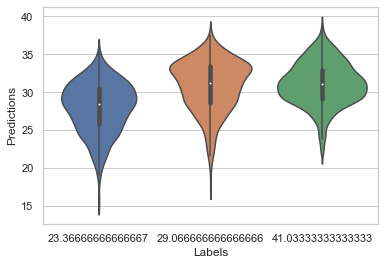

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

sns.violinplot(data=pred_label, x="Labels", y="Predictions")

# Visualisation and model inspection

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

## Random Forest Regressor

### Load model

In [62]:
rf_clf = load(os.path.join(PATH_MODELS, 'rf_clf.joblib'))
rf_clf.verbose = 0

labels = y_test
predictions = rf_clf.predict(X_test)
pred_label = pd.DataFrame(list(zip(predictions, labels)), columns =['Predictions', 'Labels'])

### Most important features

In [94]:
feature_importance = pd.DataFrame(list(zip(feature_names, rf_clf.feature_importances_)), columns =['Feature', 'Importance'])
feature_importance.sort_values(by=['Importance'], ascending=False)

,Feature,Importance
16,app_entropy_FT8,0.011043
172,energy_freq_bands_band2_F7,0.010574
9,app_entropy_T8,0.010153
23,app_entropy_T7,0.009765
2,app_entropy_OZ,0.009545
...,...,...
283,spect_edge_freq_CPZ,0.000380
295,spect_edge_freq_FC3,0.000373
284,spect_edge_freq_CZ,0.000371
289,spect_edge_freq_FCZ,0.000366


### Plot predictions

<AxesSubplot:xlabel='Labels', ylabel='Predictions'>

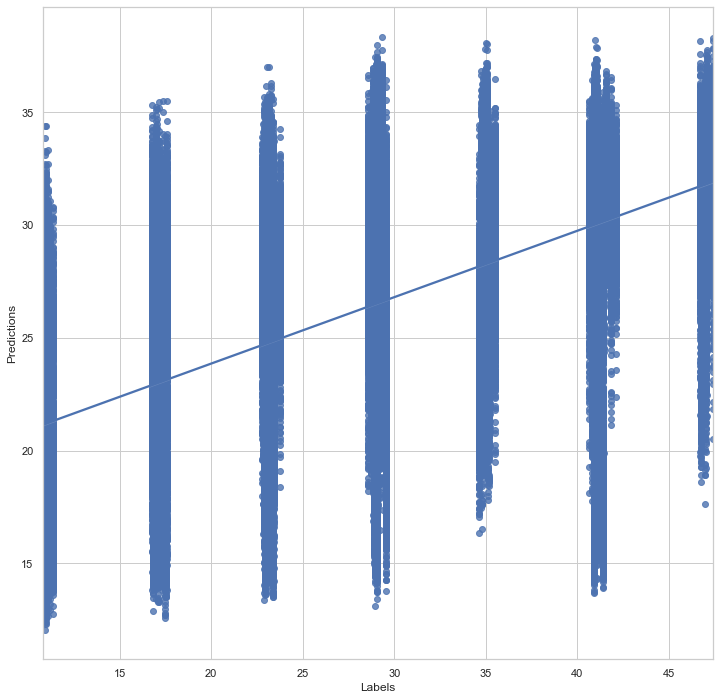

In [72]:
fig, ax = plt.subplots(figsize=(12,12))
sns.regplot(ax=ax, data=pred_label, x="Labels", y="Predictions")

## Linear Support Vector Regressor

### Load model

In [95]:
linearsvr_clf = load(os.path.join(PATH_MODELS, 'linearsvr_clf.joblib'))   
linearsvr_clf.verbose = 0

labels = y_test
predictions = linearsvr_clf.predict(X_test)
pred_label = pd.DataFrame(list(zip(predictions, labels)), columns =['Predictions', 'Labels'])

### Most important features

In [99]:
feature_importance = pd.DataFrame(list(zip(feature_names, linearsvr_clf[1].coef_)), columns =['Feature', 'Importance'])
feature_importance.sort_values(by=['Importance'], ascending=False)

,Feature,Importance
158,energy_freq_bands_band3_FC3,2.669746
43,energy_freq_bands_band3_OZ,2.318321
163,energy_freq_bands_band3_F3,2.169974
2,app_entropy_OZ,1.879167
23,app_entropy_T7,1.828985
...,...,...
123,energy_freq_bands_band3_C3,-2.164241
48,energy_freq_bands_band3_PZ,-2.291328
58,energy_freq_bands_band3_CP4,-2.364323
128,energy_freq_bands_band3_FCZ,-2.550375


### Plot predictions

<AxesSubplot:xlabel='Labels', ylabel='Predictions'>

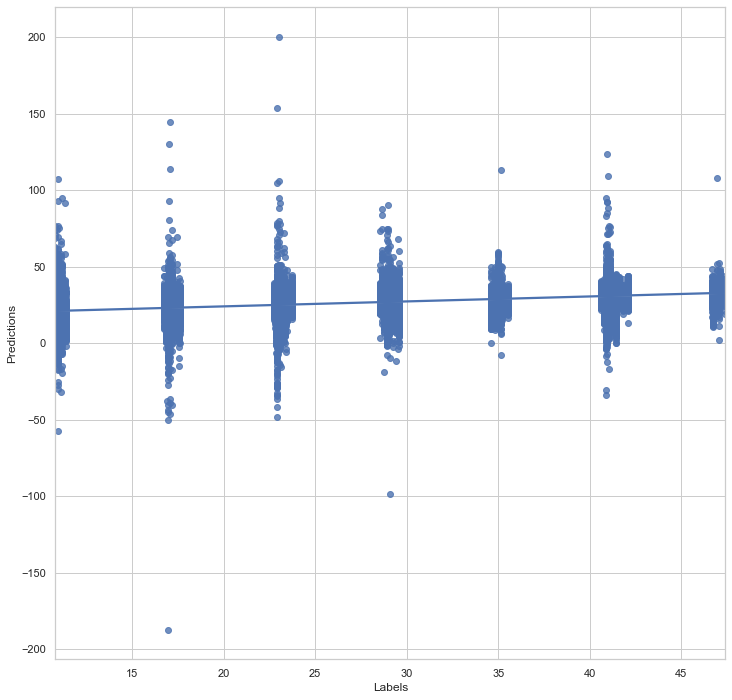

In [100]:
fig, ax = plt.subplots(figsize=(12,12))
sns.regplot(ax=ax, data=pred_label, x="Labels", y="Predictions")

## Neural network

### Load model

In [105]:
import tensorflow as tf

filename = os.path.join(PATH_MODELS, 'FC_regressor_01')
model = tf.keras.models.load_model(filename + ".hdf5")

labels = y_test
predictions = model.predict(X_test).flatten()
pred_label = pd.DataFrame(list(zip(predictions, labels)), columns =['Predictions', 'Labels'])

### Most important features

### Plot predictions

<AxesSubplot:xlabel='Labels', ylabel='Predictions'>

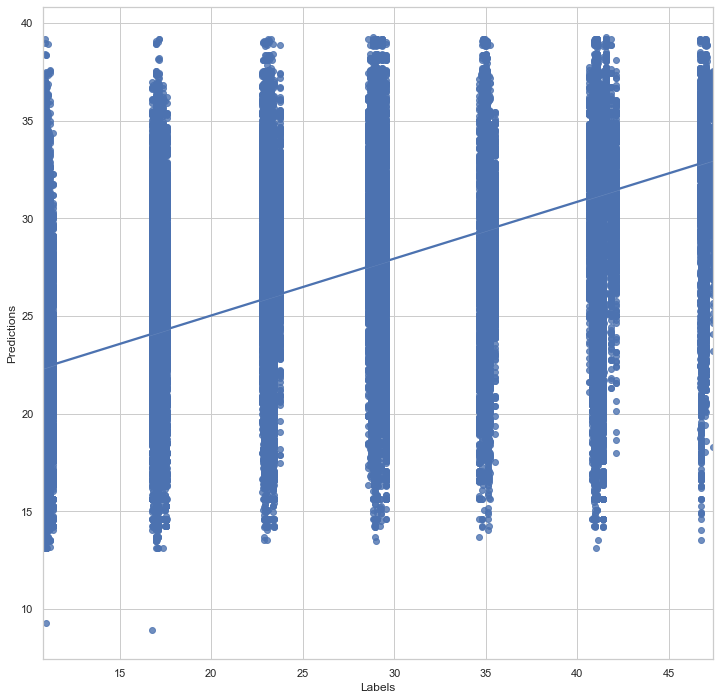

In [106]:
fig, ax = plt.subplots(figsize=(12,12))
sns.regplot(ax=ax, data=pred_label, x="Labels", y="Predictions")

## Clustering with TSNE

In [17]:
from sklearn.manifold import TSNE

# X_embedded = TSNE(n_components=2).fit_transform(X_train)
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(X_train[:10000])

<AxesSubplot:>

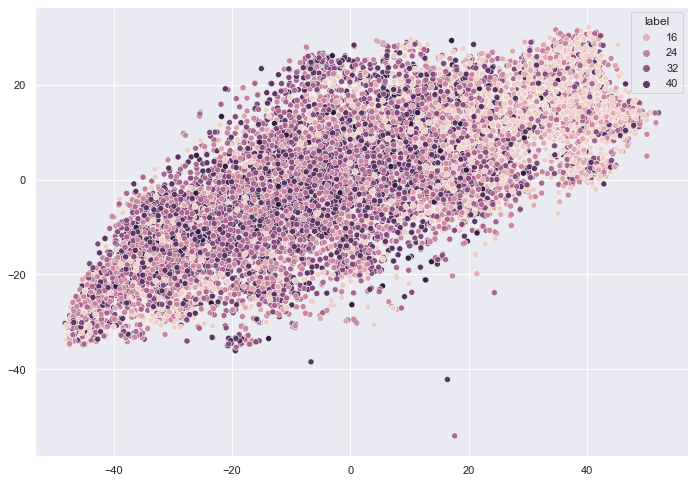

In [18]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_train[:10000])